In [2]:
##LOADING csv file

import os, sys, email
import numpy as np 
import pandas as pd
# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style('whitegrid')
#import plotly
#plotly.offline.init_notebook_mode()
#import plotly.graph_objs as go
#import wordcloud

# Network analysis
import networkx as nx
# NLP
#from nltk.tokenize.regexp import RegexpTokenizer

# ML Libraries
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
#from subprocess import check_output
#print(check_output(["ls", "../input/enron-email-dataset/"]).decode("utf8"))

#Read data into DataFrame
df = pd.read_csv('C:/Users/Sai pratham/Desktop/enron/emails.csv')
print(df.shape)
df.head()

#Sample Email from the dataset
print(df['message'][3])

##CLEANING data

#Create Helper functions (From Zichen Wang's Kernel: Explore Enron)
def get_text_from_email(msg):
    parts = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain': #extracting text data
            parts.append(part.get_payload())
    return ''.join(parts)

def split_email_adds(line): #splitting email addresses
    if line:
        addrs = line.split(',')
        addrs = frozenset(map(lambda x : x.strip(), addrs))
    else:
        addrs = None
    return addrs

(517401, 2)


,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


In [4]:
##CLEANING data

#Create Helper functions (From Zichen Wang's Kernel: Explore Enron)
def get_text_from_email(msg):
    parts = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain': #extracting text data
            parts.append(part.get_payload())
    return ''.join(parts)

def split_email_adds(line): #splitting email addresses
    if line:
        addrs = line.split(',')
        addrs = frozenset(map(lambda x : x.strip(), addrs))
    else:
        addrs = None
    return addrs

In [5]:
#create list of email objects
msgs = list(map(email.message_from_string, df['message']))
df.drop('message', axis=1, inplace=True) # axis = 1 used to apply a method across each row
# Get all fields from the email objects
fields = msgs[0].keys()
for field in fields:
    df[field] = [doc[field] for doc in msgs]
    
#parse content from emails
df['content'] = list(map(get_text_from_email, msgs))
# Split email address
df['From'] = df['From'].map(split_email_adds)
df['To'] = df['To'].map(split_email_adds)

#Extract the root of file as user
df['user'] = df['file'].map(lambda x:x.split('/')[0])
del msgs

df.head()

,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user
0,allen-p/_sent_mail/1.,<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",(phillip.allen@enron.com),(tim.belden@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n,allen-p
1,allen-p/_sent_mail/10.,<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",(phillip.allen@enron.com),(john.lavorato@enron.com),Re:,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...,allen-p
2,allen-p/_sent_mail/100.,<24216240.1075855687451.JavaMail.evans@thyme>,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",(phillip.allen@enron.com),(leah.arsdall@enron.com),Re: test,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!,allen-p
3,allen-p/_sent_mail/1000.,<13505866.1075863688222.JavaMail.evans@thyme>,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",(phillip.allen@enron.com),(randall.gay@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s...",allen-p
4,allen-p/_sent_mail/1001.,<30922949.1075863688243.JavaMail.evans@thyme>,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",(phillip.allen@enron.com),(greg.piper@enron.com),Re: Hello,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.,allen-p


In [6]:
print(df.shape)
for col in df.columns:
    print(col, df[col].nunique())

(517401, 18)
file 517401
Message-ID 517401
Date 224128
From 20328
To 54748
Subject 159290
Mime-Version 1
Content-Type 2
Content-Transfer-Encoding 3
X-From 27980
X-To 73552
X-cc 33701
X-bcc 132
X-Folder 5335
X-Origin 259
X-FileName 429
content 249025
user 150


In [7]:
df = df.set_index('Message-ID')\
.drop(['file','Mime-Version','Content-Type', 'Content-Transfer-Encoding'], axis=1)
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format = True)
df.dtypes

Date          object
From          object
To            object
Subject       object
X-From        object
X-To          object
X-cc          object
X-bcc         object
X-Folder      object
X-Origin      object
X-FileName    object
content       object
user          object
dtype: object

In [8]:
#Creating from_user list
userList = []
userList = df['user'].unique()

In [9]:
#Number of emails sent by each users

count = []
counter = 0 
for l in userList:
    for user in df['user']:
        if user == l:
            counter += 1
    count.append(counter)
    counter = 0


[(28465, 'kaminski-v'), (28234, 'dasovich-j'), (25351, 'kean-s'), (23381, 'mann-k'), (19950, 'jones-t'), (18687, 'shackleton-s'), (13875, 'taylor-m'), (13032, 'farmer-d'), (12436, 'germany-c'), (11830, 'beck-s'), (10827, 'symes-k'), (10655, 'nemec-g'), (8022, 'scott-s'), (8009, 'rogers-b'), (7823, 'bass-e'), (7329, 'sanders-r'), (6490, 'campbell-l'), (6071, 'shapiro-r'), (6054, 'guzman-m'), (5937, 'lay-k')]


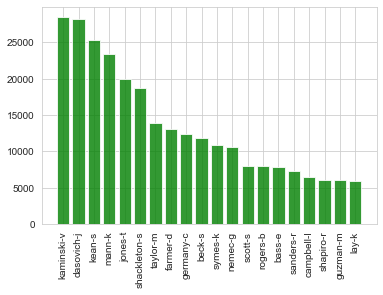

'The histogram shows users vs no. of emails they sent'

In [10]:
'''Let us take a look at how many email were sent by each user. 
This plot may indicate erratic email usage. 
We plot top 20 users who sent the highest number of emails.'''

new_list = sorted(list(zip(count, userList)), reverse = True)[:20] ##merge both lists and sort top 20, 
print(new_list)
num, mailer = zip(*new_list) ## separate lists previously merged and use them for plotting
mail = range(len(new_list))
plt.bar(mail, num, align = 'center', color ='green', alpha=0.8)
plt.xticks(mail, mailer, rotation='vertical')
plt.show()

'''The histogram shows users vs no. of emails they sent'''

In [11]:
#Read data into DataFrame
newdf = pd.read_csv('C:/Users/Sai pratham/Desktop/enron/part.csv')
print(newdf.shape)
newdf.head()

(481, 3)


,user,year,emails
0,allen-p,1980,10
1,allen-p,1999,8
2,allen-p,2000,1307
3,allen-p,2001,1704
4,allen-p,2002,5


'The graph shows which user sent the most emails in which year.'

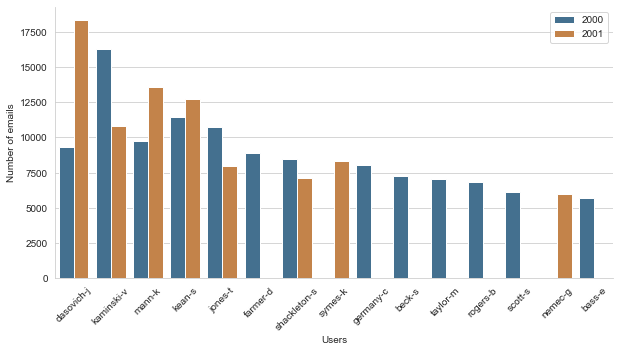

In [12]:
#The dataset imported in the previous lines was extracted using MapReduce on CloudEra Hadoop Distribution 
#from the enron-email dataset. The new dataset retrieved as a result was uploaded to kaggle in the name of
#"year-vs-number-of-emails-enron-emails".
#The dataset includes three columns -
#User - name of the user
#Year - Year in which the user sent emails
#Emails - Number of emails sent by a particular user in a particular year.
#Using the data above, we will plot a graph to look for a user who sent the most emails around the time of the scam.'''
user = newdf["user"]
year = newdf[" year"]
emails = newdf[" emails"]
listnew = sorted(list(zip(emails, user, year)), reverse = True)[:21] ##merge both lists and sort top 15,
dframe = pd.DataFrame(listnew)
dframe.columns = ['emails', 'user', 'year']
dframe.head()
#The list 'listnew' contains top users with most emails sent"

#plot
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
sns.barplot(x='user', y='emails', hue='year', data=dframe, saturation=0.5)
sns.despine()
plt.xticks(rotation=45)
plt.legend(loc='upper right')
fig.savefig('example.png')
plt.xlabel('Users')
plt.ylabel('Number of emails')


'''The graph shows which user sent the most emails in which year.'''

C:\Users\Sai pratham\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


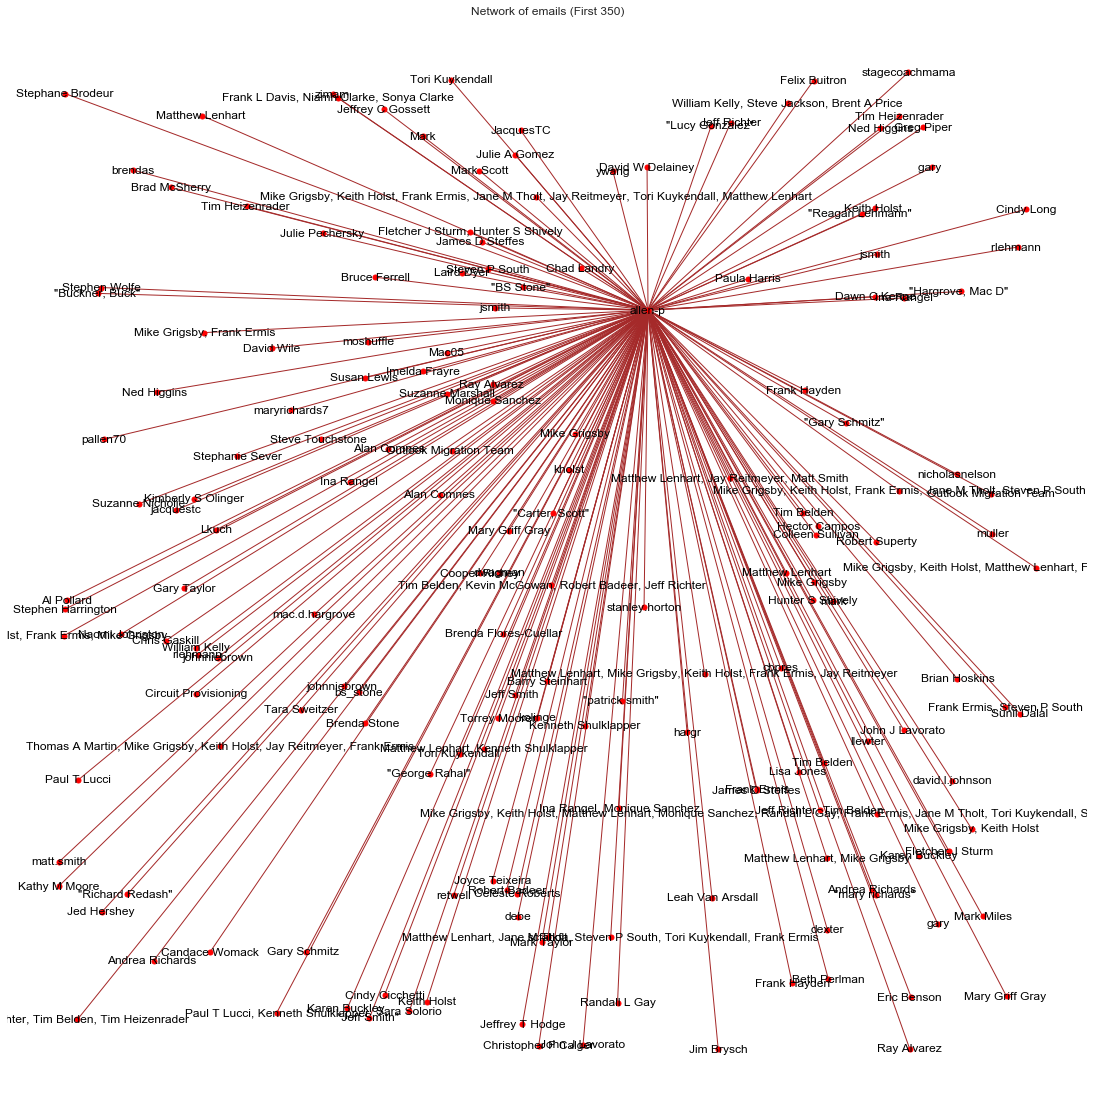

'In this graph, I attempted to visualize a network with users who sent and received emails as nodes. \nI chose to display only the first 350 emails because the graph looks clumsy with labels. \nFrom this graph, it can be noticed that the point of centrality is allen-p.'

In [13]:
# The number of emails indicates a pattern,however it also important to consider the network
# that existed in the company.
dfnew = df.head(n=350)

toUSER = []
for user in dfnew['X-To']:
    user = user.split('<')[0]
    user = user.split('@')[0]
    toUSER.append(user)
newlister = list(zip(dfnew['user'],toUSER))
datanewf = pd.DataFrame(newlister)
datanewf.columns = ['fromuser', 'touser']
G = nx.from_pandas_edgelist(datanewf, 'fromuser', 'touser')
plt.figure(figsize=(15,15))
pos = nx.draw_random(G, node_size = 25, node_color = 'red', edge_color = 'brown', with_labels = True)
plt.title('Network of emails (First 350)')
plt.show()

'''In this graph, I attempted to visualize a network with users who sent and received emails as nodes. 
I chose to display only the first 350 emails because the graph looks clumsy with labels. 
From this graph, it can be noticed that the point of centrality is allen-p.'''

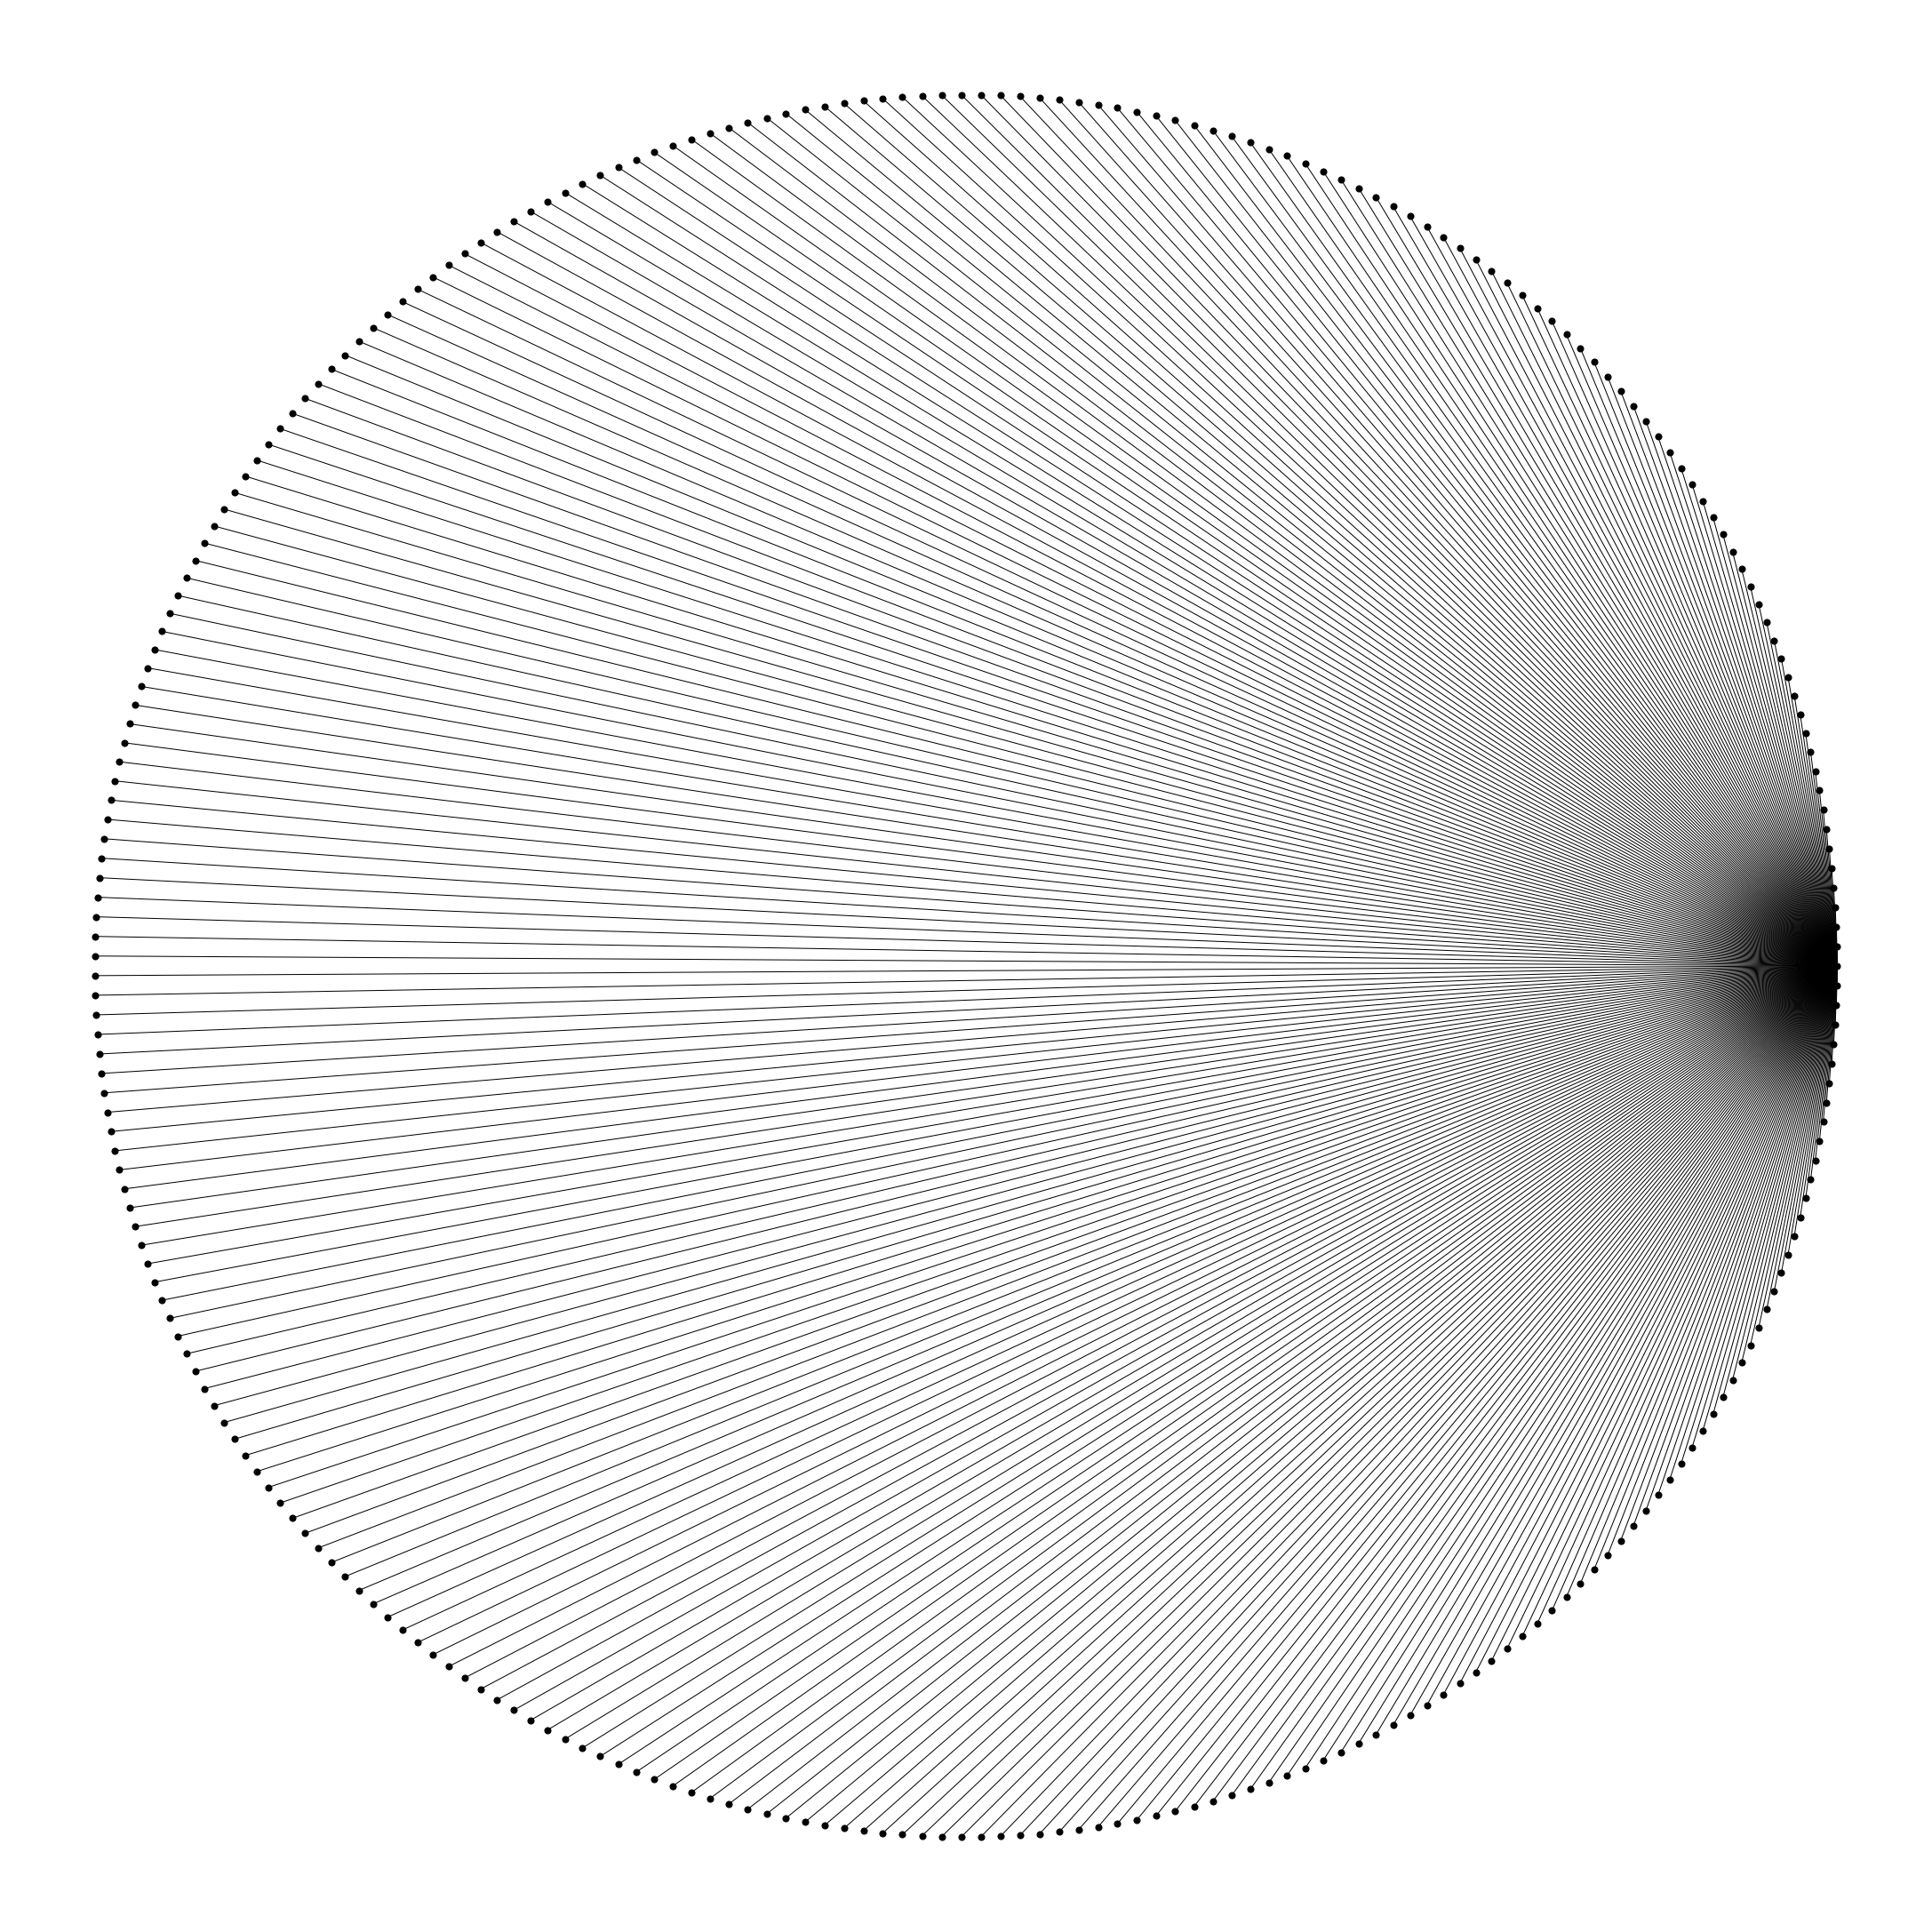

'The graph displays the network of first 1000 emails. The point of centrality is at node representing allen-p. \nTherefore, in this set of 1000 emails, the allen-p seems influential. However, this analysis is inaccurate as \nwe did not consider the total of 517000 emails.'

In [14]:
dfnew = df.head(n=1000)

toUSER = []
for user in dfnew['X-To']:
    user = user.split('<')[0]
    user = user.split('@')[0]
    toUSER.append(user)
newlister = list(zip(dfnew['user'],toUSER))
datanewf = pd.DataFrame(newlister)
datanewf.columns = ['fromuser', 'touser']
G = nx.from_pandas_edgelist(datanewf, 'fromuser', 'touser')
plt.figure(figsize=(30,30))
pos = nx.draw_circular(G, node_size = 50, node_color = 'black', edge_color = 'black', with_labels = False)
plt.show()

'''The graph displays the network of first 1000 emails. The point of centrality is at node representing allen-p. 
Therefore, in this set of 1000 emails, the allen-p seems influential. However, this analysis is inaccurate as 
we did not consider the total of 517000 emails.'''

In [15]:
emails = pd.read_csv('C:/Users/Sai pratham/Desktop/enron/emails.csv')
print(emails.shape)
emails.head()

(517401, 2)


,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


Instead of loading in all +500k emails, as it's hard to fit such data within a PC's memory, the dataset will be chunked into segments with approximately 10k each.

In [16]:
out = None
for emails in pd.read_csv('C:/Users/Sai pratham/Desktop/enron/emails.csv', chunksize = 10000):
    if out is None:
        out = emails.copy()
    else:
        out.append(emails)
    out.head()

In [17]:
print(out.shape)

(10000, 2)


In [18]:
print (out.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
file       10000 non-null object
message    10000 non-null object
dtypes: object(2)
memory usage: 156.4+ KB
None


Now the out dataframe has 10k messages separated into 2 columns "file" and "message", before working with this dataset the body message should be parsed into key-value pairs where only the sender, receiver and email body data will be extracted from the body message.

In [19]:
# extract to, from and body from each email
def email_parsing(raw_message):
    lines = raw_message.split('\n')
    email = {}
    message = ''
    keys_to_extract = ['from', 'to']
    for line in lines:
        
        if ':' not in line:
            message += line.strip()
            email['body'] = message
        else:
            pairs = line.split(':')
            key = pairs[0].lower()
            val = pairs[1].strip()
            if key in keys_to_extract:
                email[key] = val
    return email
# compile all extracted data into a single dictionary
def emails_parsing(messages):
    emails = [email_parsing(message) for message in messages]
    return {
        'body': result_append(emails, 'body'), 
        'to': result_append(emails, 'to'), 
        'from_': result_append(emails, 'from')
    }
# append all key results into single list
def result_append(emails, key):
    results = []
    for email in emails:
        if key not in email:
            results.append('')
        else:
            results.append(email[key])
    return results

In [20]:
# create a new dataframe for extracted data
extracted_data = pd.DataFrame(emails_parsing(out['message']))

In [21]:
# check any NaN values
extracted_data.isnull().any()

body     False
to       False
from_    False
dtype: bool

To this point emails has no null records, yet its well-known that better encoding of categorical data means better performance as many machine learning algorithms cannot operate on label data directly, this means categorical data must be converted to a numerical form.

In [22]:
stopwords = ENGLISH_STOP_WORDS.union(['ect', 'hou', 'com', 'recipient'])
vect = TfidfVectorizer(analyzer = 'word', stop_words = stopwords, max_df = 0.5, min_df = 2)


In [23]:
X = vect.fit_transform(extracted_data.body)

Now the email bodies are converted into a document-term matrix to visualise this matrix we need to create 2d representation of the DTM (document-term matrix)

In [ ]:
X_dense = X.todense()
coords = PCA(n_components=2).fit_transform(X_dense)
plt.scatter(coords[:, 0], coords[:, 1], c = 'm')

The next step is to find out the top keywords of each email, this can be done by creating a variable (features) that holds a list of all the words in the tf-idfs vocabulary in the same order as the columns in the matrix.

In [ ]:
features = vect.get_feature_names()

In [ ]:
def top_msg_features(X, features, row_id, top_words = 25):
    row = np.squeeze(X[row_id].toarray())
    return top_tfidf_features(row, features, top_words)

The following function top_tfidf_features takes a single row of the tf-idf matrix (corresponding to a particular message), and return the n highest scoring words (or more generally tokens or features).

In [ ]:
def top_tfidf_features(row, features, top_words = 20):
	# argsort produces the indices that orders the row by tf-idf value
	# reverse them (into descending order) and select the top words
    top_ids = np.argsort(row)[::-1][:top_words]
    top_features = [(features[i], row[i]) for i in top_ids]
    df = pd.DataFrame(top_features, columns=['features', 'score'])
    return df
'''Hence, the output of a tf-idf is a sparse matrix which doesnt support matrix operations, so a single row need first to be converted into dense format in order to apply top_tfidf_features function.'''

In [ ]:

def top_msg_features(X, features, row_id, top_words = 25):
    row = np.squeeze(X[row_id].toarray())
    return top_tfidf_features(row, features, top_words)
'''The next step is to calculate the average tf-idf score of all words across all emails, in other words the average per column of a tf-idf matrix'''

In [ ]:
def top_terms(X, features, grp_ids = None, min_tfidf = 0.1, top_words = 25):
    if grp_ids:
        msgs = X[grp_ids].toarray()
    else:
        msgs = X.toarray()
    msgs[msgs < min_tfidf] = 0
    # calculate the mean of each column across the selected rows (which results in a single row of tf-idf values)
    tfidf_means = np.mean(msgs, axis = 0)
    # then pass on to the previous func for picking out the top n words
    return top_tfidf_features(tfidf_means, features, top_words)
'''"grp_ids" takes a list of row indices which pick out some particular messages that you want to inspect providing "None" indicates, that you are interested in all messages (emails).'''

K-Means Clustering

K-means clustering is one of the simplest and popular clustering algorithms that stores k centroids that it uses to define clusters.


In [ ]:
# create classifier with 3 clusters and 100 iterations
clf = KMeans(n_clusters = 3, max_iter = 100, init = 'k-means++', n_init = 1)
labels = clf.fit_predict(X)

To visualise it, we need to make 2d coordinates from the sparse matrix.

In [ ]:
X_dense = X.todense()
pca = PCA(n_components = 2).fit(X_dense)
coords = pca.transform(X_dense)

In [ ]:
label_colours = ['c', 'm', 'r']
colours = [label_colours[i] for i in labels]
plt.scatter(coords[:, 0], coords[:, 1], c = colours)

Now as it's known which emails the model assigned to each cluster, it's possible to extract the top words per cluster.

In [ ]:
def top_words_per_cluster(X, y, features, min_tfidf = 0.1, top_words = 25):
    dfs = []

    labels = np.unique(y)
    for label in labels:
        ids = np.where(y == label) 
        features_df = top_terms(X, features, ids, min_tfidf = min_tfidf, top_words = top_words)
        features_df.label = label
        dfs.append(features_df)
    return dfs

In [ ]:
def plot_top_words(dfs):
    fig = plt.figure(figsize = (11, 8), facecolor = "w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Tf-Idf Score", labelpad = 16, fontsize = 13)
        ax.set_title("cluster = " + str(df.label), fontsize = 15)
        ax.ticklabel_format(axis = 'x', style = 'sci', scilimits = (-2, 2))
        ax.barh(x, df.score, align = 'center', color = '#7530FF')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1] + 1])
        yticks = ax.set_yticklabels(df.features)
        plt.subplots_adjust(bottom = 0.09, right = 0.97, left = 0.15, top = 0.95, wspace = 0.52)
    plt.show()

In [ ]:
tops = top_words_per_cluster(X, labels, features, 0.1, 25)

plot_top_words(tops)